# Inference and Spherical Coding

This notebook runs various benchmarks to evaluate the efficacy of Spherical Codes.

## Load the trajectory data, as usual

In [1]:
import numpy as np
import pickle 
from matplotlib import pyplot as plt 
trajectory_file = open("../spherical-code-paper/trajectories.pyo", "rb")
trajs = pickle.load(trajectory_file)
y_vec = np.array(trajs['y_vec'])
t_vec = np.array(trajs['t_vec'])
del trajs
trajectory_file.close()
del trajectory_file

Text(0, 0.5, 'Roadwise coordinate (ft)')

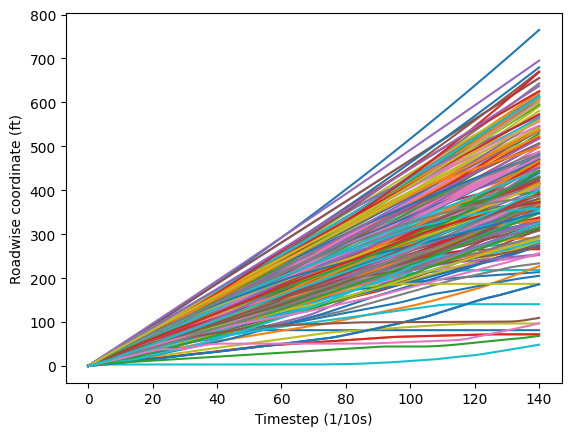

In [2]:
for traj in range(y_vec.shape[0]):
    plt.plot(y_vec[traj])
plt.xlabel('Timestep (1/10s)')
plt.ylabel('Roadwise coordinate (ft)')

This is the sample trajectory dataset

## Use FPCA basis

In [3]:
import skfda

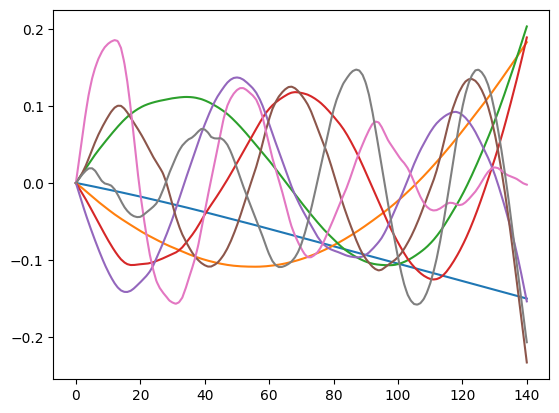

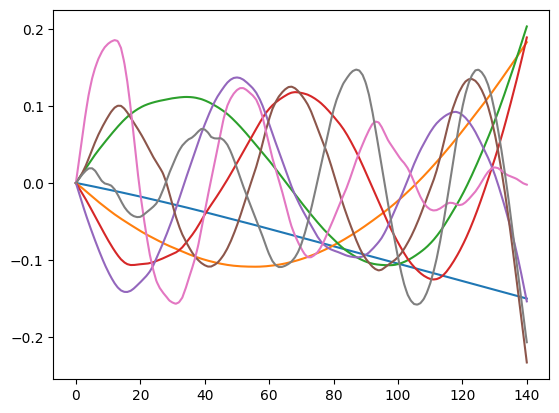

In [4]:
fdgry = skfda.FDataGrid(y_vec, np.arange(y_vec.shape[1]))
from skfda.preprocessing.dim_reduction.projection import FPCA
fpca_discretized_rw = FPCA(n_components=8)
fpca_discretized_rw.fit(fdgry)
fpca_discretized_rw.components_.plot()

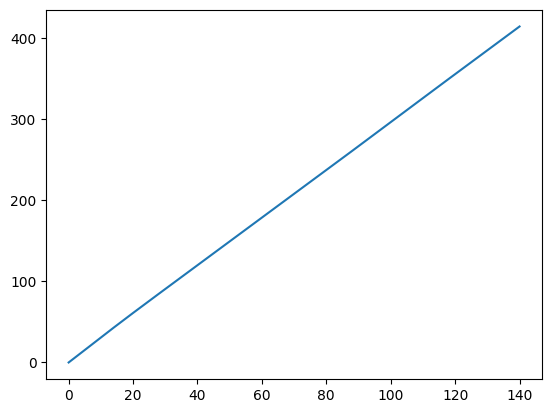

In [5]:
mean_curve = fpca_discretized_rw.mean_.data_matrix.ravel()
plt.plot(mean_curve)

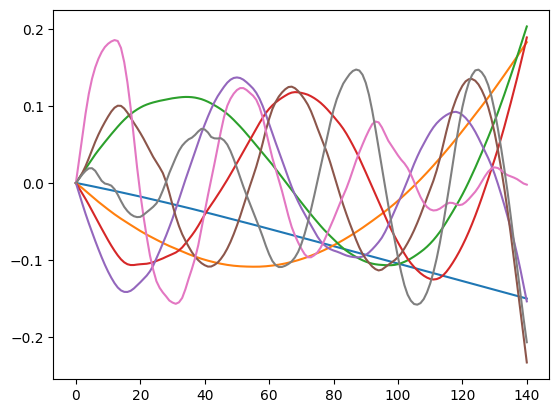

In [6]:
friendly_basis = fpca_discretized_rw.components_.data_matrix.reshape((8, -1))
for i in range(8):
    plt.plot(friendly_basis[i,:])

Convert data to the spline basis

In [7]:
y_coeffs = fpca_discretized_rw.transform(fdgry)

## Learning the prior distribution

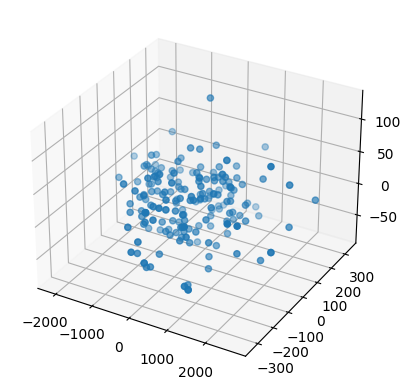

In [8]:
# Visualizing the first three components
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(y_coeffs[:,0], y_coeffs[:,1], y_coeffs[:,2])

In [9]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
bandwidth_candidates = 10 ** np.linspace(1,10,100) # 10^x from -1 to 1
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidth_candidates}, cv=LeaveOneOut())
grid.fit(y_coeffs)
#kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(y_coeffs)
#plt.hist(kde.score_samples(y_coeffs))

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.00000000e+01, 1.23284674e+01, 1.51991108e+01, 1.87381742e+01,
       2.31012970e+01, 2.84803587e+01, 3.51119173e+01, 4.32876128e+01,
       5.33669923e+01, 6.57933225e+01, 8.11130831e+01, 1.00000000e+02,
       1.23284674e+02, 1.51991108e+02, 1.87381742e+02, 2.31012970e+02,
       2.84803587e+02, 3.511191...
       8.11130831e+07, 1.00000000e+08, 1.23284674e+08, 1.51991108e+08,
       1.87381742e+08, 2.31012970e+08, 2.84803587e+08, 3.51119173e+08,
       4.32876128e+08, 5.33669923e+08, 6.57933225e+08, 8.11130831e+08,
       1.00000000e+09, 1.23284674e+09, 1.51991108e+09, 1.87381742e+09,
       2.31012970e+09, 2.84803587e+09, 3.51119173e+09, 4.32876128e+09,
       5.33669923e+09, 6.57933225e+09, 8.11130831e+09, 1.00000000e+10])})

In [10]:
kde = KernelDensity(kernel='gaussian', bandwidth=15.12).fit(y_coeffs)

In [11]:
# Save the KDE so that we don't have to learn from the data the next time the algorithm is run
with open('kde.pyo', 'wb') as f:
    pickle.dump(kde, f, pickle.HIGHEST_PROTOCOL)
print('The file has been saved successfully!')

The file has been saved successfully!


In [12]:
from scipy.stats import norm 
def likelihood(z, theta, t):
    reconstructed_trajectory = theta.T @ friendly_basis 
    #print('Mean: ', reconstructed_trajectory[t])
    #print('Test: ', z)
    #raise Exception("LALALA")
    return norm.pdf(z, loc=reconstructed_trajectory[t], scale=3.0) # scale is the std

In [13]:
# Low variance resampling
def lvr(particles, weights): # requires normalized weights first
    # return: new particles with equal weights
    M = particles.shape[0] # number of particles
    new_particles = np.zeros_like(particles)
    # new_particles_weight = np.ones((M,)) / M 
    # W = np.sum(weights)
    r = np.random.rand() / M # get a random number between 0 and 1/M
    c = weights[0]
    i = 0
    for m in range(M):
        U = r + m/M
        while U>c:
            i+=1
            c+=weights[i]
        new_particles[m] = particles[i]
    return new_particles


## Spherical codes

### Determining the lattice size

First we find the size of the distribution lattice, which is a 5D sphere with diameter 1m. As a consequence, all representation points belonging to the same lattice should not give an error larger than 1m. The following code demonstrates the idea.

Note that for B-spline basis, the maximum value of the basis value is already 1, so any representation vector whose norm is at most 1 will give an error at most 1m. 

The precise formula is:

$ ||a|| = \frac{h_{max}}{\max_t \Phi(t)} $

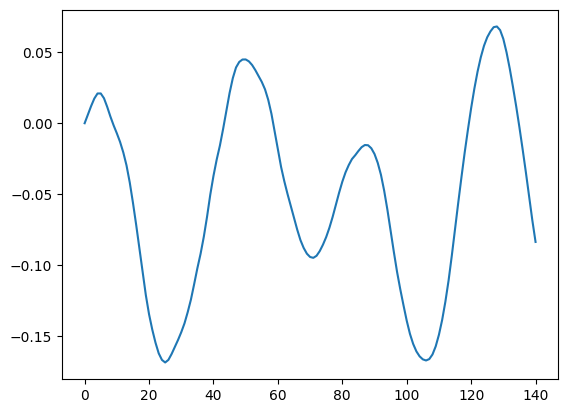

In [14]:
delta_betwn_two_pts = np.random.rand(8,)
delta_betwn_two_pts = delta_betwn_two_pts / np.linalg.norm(delta_betwn_two_pts)
error_in_time_domain = delta_betwn_two_pts.reshape((1,8)) @ friendly_basis
plt.plot(error_in_time_domain[0])

So the error stays less than 1m. As we predicted.

### Relative Inferential Spherical Coding (RISC)

First of all, the whole idea is similar to delta compression: as the estimation of the representation vector $a$ gets better with observations arriving, we will subsequently broadcast the change to other vehicles, which is the delta compared to the last estimate. All MAP estimates start from the prior's mean $\overline{a}$, then gradually moves to the corresponding generating representation vector $a^*$.

Encoding the radial component should be simple: we send a 1 if we want to move to the next annulus of lattice in the outward radial direction. We send a 0 if we want to move in inward radial direction. Overall, the less common the trajectory is, the more bits we have to send (in multiple attempts) to other vehicles. Vice-versa, because most trajectories can be represented close to the mean, we expect to send little bits to determine the "correct" annulus $a^*$ is in.

In [15]:
from scipy.stats import norm 
# from coding import huffman
import sys 

In [16]:
def angular_minus(a,b):
    d = np.mod(a - b, np.pi * 2)
    return (d > np.pi) * (np.pi * 2 - d) + (d <= np.pi) * d

We are going to test against multiple trajectories, each trajectory will have 2 configurations: a uniform distribution and a spherical code distribution

This is the code for one configuration, we have to copy it and run two times.

In [17]:
np.random.seed(6969)
test_trajectory_index = np.random.randint(y_vec.shape[0], size=20) # total number of trajectories to test on
# To store the test results
map_particle_log = np.zeros((test_trajectory_index.shape[0], 140, 8)) # store the MAP (PF's estimate) through time, each with 5 components corresponding to 5 basis functions
test_bits_log = np.zeros((test_trajectory_index.shape[0], 140)) # set 140 to y_test below too
recons_err_log = np.zeros((test_trajectory_index.shape[0], 140))
n_transmissions = np.zeros((test_trajectory_index.shape[0])) # to log the number of transmission attempts
n_transmission_time = [] # to log the time between transmissions                     
test_configuration = 'uniform' # spherical or uniform

for test_no, y_test_id in enumerate(test_trajectory_index.tolist()):
    n_transmission_time.append([0]) # transmission always starts at time 0
    # generate the test trajectory
    y_test = y_vec[y_test_id,:140] - mean_curve[:140] # remove the mean
    print('Test number {}/{} (trajectory {}) '.format(test_no + 1, test_trajectory_index.shape[0], y_test_id))

    ###

    n_particles = 5000 
    map_particle_available = False

    # Step 1: generate a bunch of particles from the prior distribution
    particles = kde.sample(n_particles, random_state=6969)
    weights = np.ones((n_particles,)) / n_particles
    map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
    weights_variance_log = np.zeros((y_test.shape[0],))
    measurement_likelihood_log = np.zeros((y_test.shape[0],))
    error_log = np.zeros((y_test.shape[0],)) # the error we observe (due to MAPE has changed)
    reconstruction_error_log = np.zeros_like(error_log) # the error our clients will observe
    broadcast_log = np.zeros((y_test.shape[0],))
    bits_log = []
    last_transmission_at_time = 0
    # Some debuggin variables
    beta_sd_history = np.zeros((y_test.shape[0], 7)) # n_basis -1 
    betac_history = np.zeros((y_test.shape[0], 7))


    lattice_size = 1/np.sqrt(np.shape(particles[0])[0]) # 1/sqrt(5) in case of 5 basis components

    for t in range(y_test.shape[0]):
        # When measurement arrives, calculate the importance weights first
        weights_normalization_coeff = 0
        for j in range(weights.shape[0]):
            measurement_likelihood = likelihood(y_test[t], particles[j,:], t)
            weights[j] = measurement_likelihood
            weights_normalization_coeff += weights[j]
            measurement_likelihood_log[t] += measurement_likelihood

        # print(t, measurement_likelihood)

        # Normalization all the weights
        for j in range(weights.shape[0]):
            weights[j] = weights[j] / weights_normalization_coeff
        
        if not map_particle_available: # first assignment of map_particle_value
            # Get the index of the particle with largest weight, that will be our maximum-a-posteriori estimate 
            map_particle_index = np.argmax(weights)
            map_particle_value = particles[map_particle_index]
            mean_particle = map_particle_value.copy()
            map_components_log[t,:] = map_particle_value
            map_particle_available = True

            # Intialization of variables at the beginning of the inference process
            alpha = np.zeros_like(mean_particle)
            # alphac = np.zeros_like(alpha)
            beta = np.zeros((np.shape(mean_particle)[0]-1,))
            beta_mean = beta.copy() # this is the smoothed out mean of the beta vector using beta in the past for which we will use to build the Huffman's probability table 
            # beta_sd = np.ones_like(beta_mean) * np.pi / 4 # this is the variance vector to accompany with the mean vector above
            beta_sd = np.ones_like(beta_mean) * np.pi * 4 # starting from a more uniform distribution
            betaq = np.zeros_like(beta)
            rq = 0 
            phi = np.zeros_like(beta)
            phiq = np.zeros_like(beta)
            map_particle_value_c = map_particle_value.copy()
            
            
        error_log[t] = np.abs(((map_particle_value_c) @ friendly_basis)[t] - y_test[t])
        
        map_particle_index = np.argmax(weights)
        map_particle_value_new = particles[map_particle_index]
        map_particle_log[test_no, t, :] = map_particle_value_new.copy()
        
        if error_log[t] > 3.0: # if the prediction from MAP deviates up to 3ft from the actual observations
            # Add 1 to the number of transmission attempts
            n_transmissions[test_no] += 1
            n_transmission_time[test_no].append(t - last_transmission_at_time)
            
            # we will have to broadcast an update so that our fellows can adjust accordingly
            alpha_new = map_particle_value_new - mean_particle
            delta = alpha_new - alpha # the delta message to broadcast
            
            # calculating radial component
            delta_r = np.linalg.norm(delta) # change in radius
            delta_rq = np.floor(delta_r / lattice_size) # quantized change in radius
            delta_rc = delta_rq * lattice_size # reconstructed change in radius 
            r_bits = delta_rq
            if delta_rc == 0: 
                delta_rc = 1
                r_entropy = 1
            else:
                r_entropy = np.log2(delta_rq) 

            last_transmission_at_time = t


            # calculating the spherical coordinates (i.e., the beta vector)
            beta_new = np.zeros((np.shape(mean_particle)[0]-1,))
            for dimension in range(np.shape(mean_particle)[0]-1):
                # formula for spherical coordinates (first 3 components)
                beta_new[dimension] = np.arccos(delta[dimension]/np.linalg.norm(delta[dimension:]))
            # spherical coordinate for the final component
            if delta[-1] >= 0:
                beta_new[-1] = np.arccos(delta[-2]/np.linalg.norm(delta[-2:]))
            else:
                beta_new[-1] = 2 * np.pi - np.arccos(delta[-2]/np.linalg.norm(delta[-2:]))

            # quantizing the spherical coordinates
            number_of_lattices = np.floor(2 * np.pi * delta_rc / lattice_size) + 1
            phi_new = np.zeros_like(beta_new)
            betac_new = np.zeros_like(phi_new)
            for dimension in range(np.shape(mean_particle)[0]-1):
                phi_new[dimension] = np.floor(delta_rc * beta_new[dimension] / lattice_size) # to be encoded with Huffman
                betac_new[dimension] = phi_new[dimension] * lattice_size / delta_rc # to be used with rc to reconstruct the alphac vector

            # reconstruct the alpha vector (the thing our clients will get)
            deltac = np.zeros_like(alpha_new)
            for i in range(np.shape(mean_particle)[0]-1):
                v = delta_rc
                for k in range(i):
                    v = v * np.sin(betac_new[k])
                v = v * np.cos(betac_new[i])  
                deltac[i] = v 
            deltac[-1] = deltac[-2] / np.cos(betac_new[-1]) * np.sin(betac_new[-1])

            # Reconstruction of the MAP particle from what the client receives
            alphac_new = alpha + deltac # this is what our client will get
            map_particle_value_c = alphac_new + mean_particle # this is the particle our client will use to extrapolate the trajectory 

            # print('Alpha distance: ', np.linalg.norm(alphac_new - alpha_new))

            # encode the phi_new vector 
            phi_entropy = 0
            phi_bits = np.zeros_like(phi_new)
            phi_prob = np.zeros_like(phi_bits)
            for dimension in range(np.shape(mean_particle)[0]-1):
                # first, we need to create a probability table to derive Huffman's code
                if number_of_lattices < 2: # ensure there will be a minimum of 2 lattices to encode
                    p_lattice = np.ones((2,))
                else:
                    p_lattice = np.zeros((int(number_of_lattices),))
                for i in range(int(number_of_lattices)):
                    if test_configuration == 'spherical':
                        p_lattice[i] = norm.pdf(angular_minus(2 * np.pi / number_of_lattices * i, beta_mean[dimension]), 0, beta_sd[dimension])
                    elif test_configuration == 'uniform':
                        p_lattice[i] = 1 # uniform
                    else:
                        raise Exception('test_configuration is not set')
                if np.linalg.norm(p_lattice) < 1e-2:
                    p_lattice = np.ones_like(p_lattice) # preventing p_lattice from being too small
                p_lattice = p_lattice / np.linalg.norm(p_lattice)
                # generate the Huffman code (see Useful Snippet 1 below)
                p_lattice_sort_arg = np.argsort(p_lattice)[::-1]
                p_lattice_sorted = p_lattice[p_lattice_sort_arg]
                p_lattice_sort_map = np.argsort(p_lattice_sort_arg)
                # generate Huffman code
                if test_configuration == 'spherical': # switch to True if we want Huffman's code
                    # code = huffman.HuffmanCode(p_lattice_sorted.tolist())
                    # spherical_code = code.compute_code()

                    # for index, s in enumerate(spherical_code):
                    #     if s == '':
                    #         spherical_code[index] = '0'
                    raise Exception("Huffman code is not supported in this notebook!")

                phi_prob[dimension] = p_lattice_sorted[p_lattice_sort_map[int(phi_new[dimension])]] # actually a constant in uniform code
                if test_configuration == 'spherical':
                    # phi_bits[dimension] = int(spherical_code[p_lattice_sort_map[int(phi_new[dimension])]], 2) # convert a string of binary to int
                    raise Exception("Huffman code is not supported in this notebook!")
                elif test_configuration == 'uniform':
                    phi_bits[dimension] = int(phi_new[dimension])
                if phi_bits[dimension]<1e-2:
                    phi_bits[dimension] += 0
                else:
                    phi_entropy += np.log2(phi_bits[dimension])

            # Update beta_mean and beta_sd
            angular_dist = angular_minus(betac_new, beta_mean)
            beta_mean = 0.3 * beta_mean + 0.7 * betac_new 
            beta_sd = 0.7 * (np.abs(angular_dist) * 1.96) + 0.3 * beta_sd

            # print('Radial/angular delta vector: {} / {}'.format(r_bits, phi_bits))
            if False: #silencing the logging process
                print('Codeword proba: ', phi_prob)
                print('Ang dist btwn trans (deg): {}'.format(angular_dist / np.pi * 180))
                print('Rad bits / Ang bits: {:.2f}/{:.2f}'.format(r_entropy, phi_entropy))
                #print('W/O bef/aft cmpr: {:.0f} -> {:.0f} ({:.2f}%) bits'.format(5 * 32, r_entropy + phi_entropy, (r_entropy + phi_entropy) / (5 * 64) * 100))
                print('--- END OF TRANSMISSION ATTEMPT ---')
            

            # Assign new values to current values
            # map_particle_value = map_particle_value_new_c.copy() # should reconstruct alpha from quantized parameters and place it here
            alpha = alphac_new.copy()
            beta = betac_new.copy() # reconstructed from quantization 
            phi = phi_new.copy()  # reconstructed from quantization too
            map_components_log[t,:] = map_particle_value_c
            broadcast_log[t] = 1
            bits_log.append(r_entropy + phi_entropy)
            # logging for debugging
            beta_sd_history[t,:] = beta_sd
            betac_history[t,:] = betac_new

            test_bits_log[test_no, t] = r_entropy + phi_entropy # for batch testing log

            # sys.exit()

        reconstruction_error_log[t] = np.abs(((map_particle_value_c) @ friendly_basis)[t] - y_test[t])
        recons_err_log[test_no, t] = reconstruction_error_log[t] 
        
        if reconstruction_error_log[t] > 2.00:
            # raise Exception("While this error is so high?")
            pass 
        
        # Resample the particles according to the particle weights
        if measurement_likelihood_log[t] < 100:
            particles = lvr(particles, weights)
            weights = np.ones((n_particles,)) / n_particles

        weights_variance_log[t] = np.var(weights)


    ###
    
    

Test number 1/20 (trajectory 95) 
Test number 2/20 (trajectory 86) 
Test number 3/20 (trajectory 188) 
Test number 4/20 (trajectory 178) 
Test number 5/20 (trajectory 113) 
Test number 6/20 (trajectory 136) 
Test number 7/20 (trajectory 192) 
Test number 8/20 (trajectory 63) 
Test number 9/20 (trajectory 56) 
Test number 10/20 (trajectory 97) 
Test number 11/20 (trajectory 49) 
Test number 12/20 (trajectory 101) 
Test number 13/20 (trajectory 64) 
Test number 14/20 (trajectory 188) 
Test number 15/20 (trajectory 2) 
Test number 16/20 (trajectory 173) 
Test number 17/20 (trajectory 167) 
Test number 18/20 (trajectory 78) 
Test number 19/20 (trajectory 149) 
Test number 20/20 (trajectory 165) 


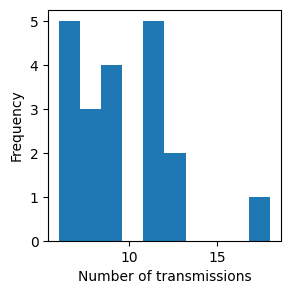

In [20]:
plt.figure(figsize=(3,3))
plt.hist(n_transmissions)
plt.xlabel('Number of transmissions')
plt.ylabel('Frequency')
plt.savefig('sc_n_transmissions.pdf', bbox_inches='tight')

In [21]:
# Convert nested list to array
trans_time = np.array([item for s in n_transmission_time for item in s])

In [24]:
trans_time

array([ 0, 16, 16,  8, 18,  8,  6, 11,  0,  3, 12,  8, 33,  4,  7, 23, 34,
        9,  3,  2,  0,  6,  8,  5,  8, 50,  7, 49,  2,  0,  3, 14,  4, 20,
        6,  7, 24,  6,  7, 31, 13,  0,  4, 33, 17, 38,  6, 14,  5,  0, 14,
        7,  9, 27,  4,  8, 33, 10, 24,  0, 15, 25, 20, 26, 45,  4,  0, 15,
       10,  3, 14,  3, 18,  6, 25, 14,  5,  4,  4,  4,  0,  8,  9, 10, 10,
       11, 18,  6,  4, 19,  9, 11,  0, 14,  3,  4,  4,  9,  7,  8,  9,  6,
       33, 17,  3, 19,  0,  6, 13, 39,  4, 14,  7, 10, 36, 10,  0,  3, 23,
       16,  7, 17, 12,  0, 12, 10, 12, 32,  5, 10,  9,  3, 26, 16,  3,  0,
        6,  8,  5,  8, 50,  7, 49,  2,  0,  4, 14,  7,  9,  5, 11, 28, 20,
       16, 20,  5,  0,  5,  6, 29, 20,  4,  6, 17,  5, 25,  0, 16,  6, 29,
       26,  8, 39,  4,  6,  0, 20,  5,  7,  7,  4, 25,  0, 16,  8,  6, 11,
       10,  5,  3,  6,  9,  4,  5,  5,  3,  4,  9, 12,  5, 11,  0,  3, 13,
       19,  3,  5,  6, 76,  4,  6])

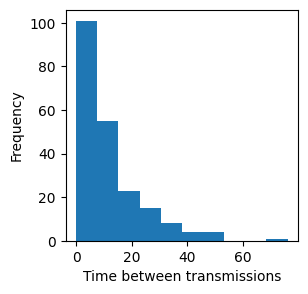

In [23]:
plt.figure(figsize=(3,3))
plt.hist(trans_time)
plt.xlabel('Time between transmissions')
plt.ylabel('Frequency')
plt.savefig('sc_t_transmission.pdf', bbox_inches='tight')

In [32]:
print('Mean of number of transmissions: ', np.mean(n_transmissions))
print('STD of number of transmissions: ', np.std(n_transmissions))
print('-')
print('Mean of time between transmissions: ', np.mean(trans_time))
print('STD of time between transmissions: ', np.std(trans_time))

Mean of number of transmissions:  9.55
STD of number of transmissions:  2.8718460961548757
-
Mean of time between transmissions:  11.706161137440759
STD of time between transmissions:  11.479588725257058


# Legacy code

In [18]:
plt.figure(figsize=(5,2))
for dimension in range(5):
    plt.plot(map_components_log_zero_shifted[:,dimension], 'o', label='{:d}'.format(dimension+1))
plt_y_max = np.max(map_components_log.ravel())
plt_y_min = np.min(map_components_log.ravel())
plt.ylim((plt_y_min+50, plt_y_max+50))
plt.legend()
plt.xlabel('Time (1/10s)')
plt.ylabel('Repr. value')
plt.savefig('broadcast_attempts.pdf')

NameError: name 'map_components_log_zero_shifted' is not defined

<Figure size 500x200 with 0 Axes>

In [ ]:
map_components_log_zero_shifted[83,:]

Reconstruction of the original trajectory from the latest estimation:

In [ ]:
reconstructed_y_from_latest = map_components_log_zero_shifted[83,:].reshape((-1,1)).T @ friendly_basis
reconstructed_y_from_latest = reconstructed_y_from_latest.ravel()
plt.plot(reconstructed_y_from_latest + mean_curve[:141], label='Reconstructed')
plt.plot(y_test + mean_curve[:140], label='Original')
plt.figure()
plt.plot(reconstructed_y_from_latest[:140] - y_test, label='Reconstruction error')

Let's plot the reconstructed trajectory, and compare it to the original trajectory:

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(reconstruction_error_log + y_test, label='Reconstruction')
plt.plot(y_test, '--', linewidth=0.5, label='Ground truth')
plt.xlabel('Time (1/10s)')
plt.ylabel('Roadwise coord. (ft)')
plt.legend()
plt.subplot(2,1,2)
plt.plot(reconstruction_error_log)
plt.xlabel('Time (1/10s)')
plt.ylabel('Roadwise coord. (ft)')
plt.tight_layout()
plt.savefig('reconstruction.pdf')

The map_components_log variable contains a bunch of lines with zeros, let's remove them:

In [ ]:
deltas = map_components_log[~np.all(map_components_log == 0, axis=1)]
print(deltas[:3])

Calculation of the bits of the message payload

In [ ]:
payload_bits = test_bits_log[test_bits_log!=0]

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(payload_bits)
plt.xticks(np.arange(0,10,1))
plt.xlabel('nth Delta message payload bits')
plt.ylabel('Bits')
plt.savefig('payload_bits.pdf')

Visualization of transmission scheme: frequency and amount of bits

In [ ]:
for test in range(test_bits_log.shape[0]):
    plt.plot(test_bits_log[test,:])

In [ ]:
# Post analysis code
# Calculate the minimum number of bits transmitted
test_total_bits_transmitted = np.zeros((test_bits_log.shape[0],))
for i in range(test_bits_log.shape[0]):
    test_total_bits_transmitted[i] = np.sum(np.where(test_bits_log[i,:] > 0.9, test_bits_log[i,:], 0))

In [ ]:
# Histogram of total bits transmitted
plt.hist(test_total_bits_transmitted, bins=20)
print('Mean: ', np.average(test_total_bits_transmitted))
print('STD: ', np.std(test_total_bits_transmitted))

Visualization of residual error

In [ ]:
for test in range(test_bits_log.shape[0]):
    plt.plot(recons_err_log[test,:])

print('Mean error: ', np.average(recons_err_log.reshape(-1)))
print('Std error: ', np.std(recons_err_log.reshape(-1)))